In [1]:
%matplotlib inline

# libraries for imbalanced learning
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

import pandas as pd
import numpy as np
from utility_functions import report

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Echonest audio features - IMBALANCED LEARNING
## 1. Premise
The hyper-parameters and results for unbalanced classifiers are taken  from the notebooks:
- bin-genre_decision-tree_KNN  (section 2.1)
- multi-genre_decision-tree-KNN   (section 2.2)
- popularity_decision-tree_KNN    (section 2.3)
Below we report their score and AUC curve for comparing them with the balanced data.

We use PCA to project the dimension of the dataset using only the first 2 principal components.

__________________________________
# 2.1 Binary genre - ROCK & JAZZ
__________________________________
## a) Import dataset

In [2]:
binclass_dataset = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/Data/Dataset [cleaned]/echo_audiofeatures_genres.csv')
binclass_dataset.set_index('track_id', inplace=True)
binclass_dataset = binclass_dataset[binclass_dataset['genre_top'].isin(['Rock','Jazz'])]
binclass_dataset.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
track_id,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,128.537,0.788251,Jazz
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,120.790,0.650452,Jazz
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,135.468,0.682397,Jazz
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,120.218,0.917613,Jazz
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [3]:
print('Class distribution before balancing')
pd.concat(
    [binclass_dataset.genre_top.value_counts(),
                round(binclass_dataset.genre_top.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

Class distribution before balancing


,counts,percentage (%)
Rock,3892,94.17
Jazz,241,5.83


In [4]:
# Data preprocessing
le = preprocessing.LabelEncoder()
binclass_dataset['genre_top'] = le.fit_transform(binclass_dataset['genre_top'])
print('Legend:\n0: Jazz\n1: Rock')
# Define the labels
labels = binclass_dataset[['genre_top']]
labels.reset_index(drop=True, inplace=True)
labels = labels['genre_top']

Legend:
0: Jazz
1: Rock


In [5]:
# remove labels from dataset
binclass_dataset.drop('genre_top', axis=1, inplace=True)

In [6]:
labels.head()

0    0
1    0
2    0
3    0
4    1
Name: genre_top, dtype: int64

In [7]:
# normalize the dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(binclass_dataset)

## b) Plot class distribution in 2D

In [8]:
# using optimal number of components: 6 ( discovered in the notebook mentioned above)
pca = PCA(6,random_state=42)
pca.fit(scaled_features)
#print(pca.explained_variance_ratio_) # amount of variance explained by each component
X = pca.transform(scaled_features)

In [9]:
X, X_test, y, y_test = train_test_split(X, labels, test_size=0.30, random_state=42)

In [10]:
print('Class distribution before balancing after splitting in train test')
pd.concat(
    [y.value_counts(),
                round(y.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

Class distribution before balancing after splitting in train test


,counts,percentage (%)
1,2717,93.92
0,176,6.08


In [11]:
# function for plotting data in 2D with PCA
def pca_2D(X, y, graph_title):
    """
    This function plots in 2D the features of X.
    :param X: array of features
    :param y: labels
    :param graph_title: title to be displayed on the graph
    :return: 2D scatter-plot
    """
    # dataframe for plotting PCA
    df = pd.DataFrame()
    df['pca1'] = X[:,0]
    df['pca2'] = X[:,1]
    df['genres'] = y.apply(lambda x: "Rock" if x==1 else "Jazz")
    # plot scatter of PCA
    plt.figure(figsize=(10,7))
    sns.scatterplot(
        x="pca1", y="pca2",
        hue='genres',
        palette={'Jazz':'darkblue','Rock':'red'},
        data=df,
        legend="full",
        alpha=0.9
    )
    plt.title(graph_title, fontsize= 15)
    plt.show()

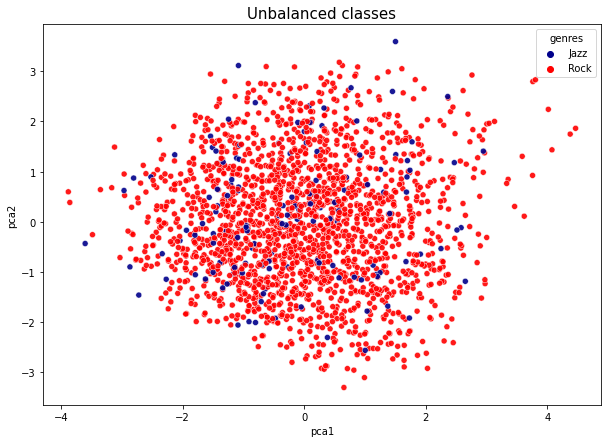

In [12]:
pca_2D(X,y,'Unbalanced classes')

## c) Imbalanced learning:
#### c.1) Undersampling - Random

In [13]:
under_sample = RandomUnderSampler(random_state=42)
# Store under-sampled data
X_under, y_under = under_sample.fit_resample(X,y)

In [14]:
print('Legend:\n0: Jazz\n1: Rock\nClass distribution after Random Undersampling:')
y_under.value_counts()

Legend:
0: Jazz
1: Rock
Class distribution after Random Undersampling:


0    176
1    176
Name: genre_top, dtype: int64

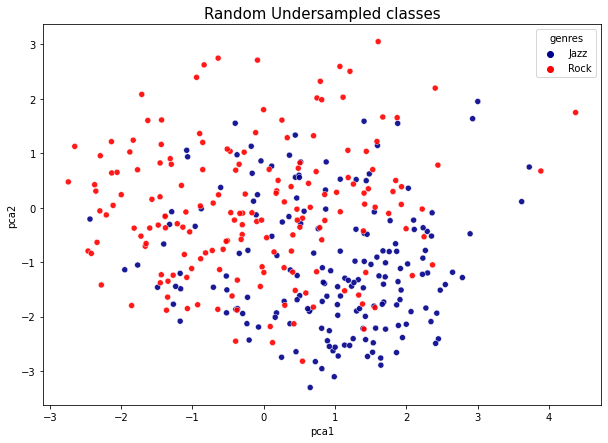

In [15]:
pca_2D(X_under,y_under,'Random Undersampled classes')

#### c.2) Condensed Nearest Neighbor (CNN)

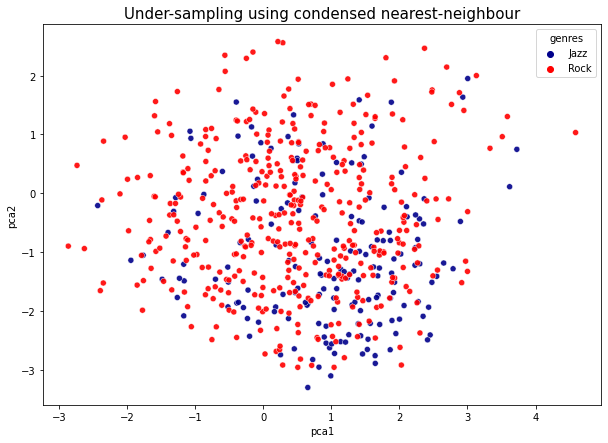

In [16]:
# Apply Condensed Nearest Neighbours
cnn = CondensedNearestNeighbour()
X_cnn, y_cnn = cnn.fit_resample(X, y)
#X_res_vis = pca.transform(X_resampled)
pca_2D(X_cnn,y_cnn,'Under-sampling using condensed nearest-neighbour')

#### c.3) Tomek's Link

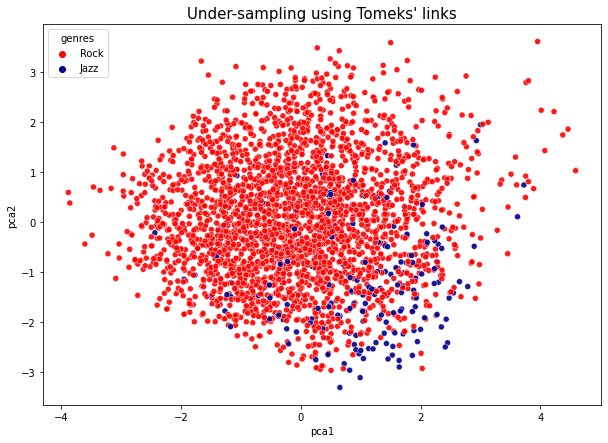

In [17]:
tomeks = TomekLinks()
X_tomek, y_tomek = tomeks.fit_resample(X, y)

pca_2D(X_tomek, y_tomek, 'Under-sampling using Tomeks\' links')

#### c.4) Oversampling - Random

In [18]:
over_sample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = over_sample.fit_resample(X, y)

In [19]:
X_over.shape, y_over.shape

((5434, 6), (5434,))

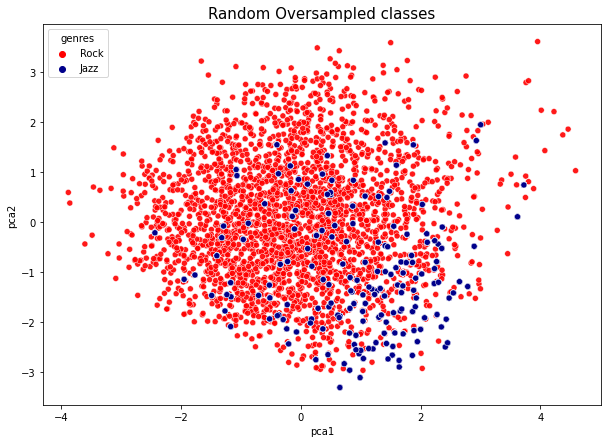

In [20]:
pca_2D(X_over, y_over, 'Random Oversampled classes')

#### c.5) SMOTE

In [21]:
smote_over = SMOTE()
X_smote, y_smote = smote_over.fit_resample(X, y)
X_smote.shape, y_smote.shape

((5434, 6), (5434,))

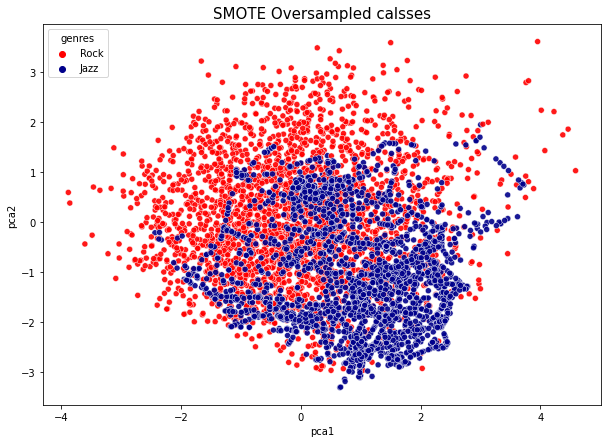

In [22]:
pca_2D(X_smote, y_smote, 'SMOTE Oversampled calsses')

#### c.6) ADASYN

In [23]:
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

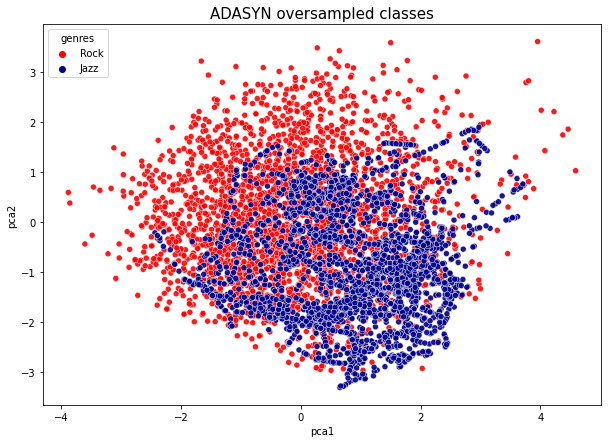

In [24]:
pca_2D(X_adasyn, y_adasyn, "ADASYN oversampled classes")

#### c.7) Class Weight

#### c.8) Ensamble (** not in the program)

_____________________________________________________________________________________________________________________

## d) Decision tree

### d.2) Unbalanced vs Balanced

In [31]:
data =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),(X_smote,y_smote),(X_adasyn,y_adasyn)]
titles =['unbalanced','undersampling','condensed NN','Tomek links', 'oversampling','SMOTE','ADASYN' ]
roc_curves ={}
fpr_tpr = []
for bal_data,title in zip(data,titles):
    dt = DecisionTreeClassifier(criterion= 'gini',max_depth=5, min_samples_leaf= 25)
    dt.fit(bal_data[0],bal_data[1])
    y_pred = dt.predict(X_test)

    # computes roc curve for each classifier
    y_score = dt.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_curves[title] = roc_auc
    fpr_tpr.append((fpr,tpr))

    print(f"*** {title} classification ***")
    print('AUC score %s' % roc_auc_score(y_test, y_pred))
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))

*** unbalanced classification ***
AUC score 0.5790834697217676
Accuracy 0.9459677419354838
F1-score [0.24719101 0.97197825]

              precision    recall  f1-score   support

           0       0.46      0.17      0.25        65
           1       0.96      0.99      0.97      1175

    accuracy                           0.95      1240
   macro avg       0.71      0.58      0.61      1240
weighted avg       0.93      0.95      0.93      1240

*** undersampling classification ***
AUC score 0.6820621931260229
Accuracy 0.7830645161290323
F1-score [0.21574344 0.8741226 ]

              precision    recall  f1-score   support

           0       0.13      0.57      0.22        65
           1       0.97      0.79      0.87      1175

    accuracy                           0.78      1240
   macro avg       0.55      0.68      0.54      1240
weighted avg       0.93      0.78      0.84      1240

*** condensed NN classification ***
AUC score 0.6484124386252046
Accuracy 0.9120967741935484


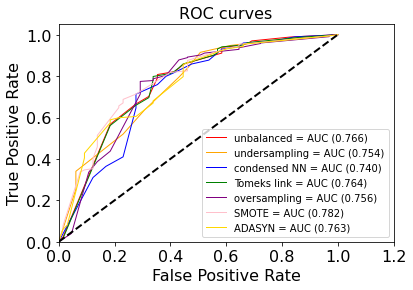

In [55]:
# plot roc curves

plt.plot(fpr_tpr[0][0], fpr_tpr[0][1], color='red', lw=1, label='unbalanced = AUC (%.3f)' % roc_curves['unbalanced'])
plt.plot(fpr_tpr[1][0], fpr_tpr[1][1], color='orange', lw=1, label='undersampling = AUC (%.3f)' % roc_curves['undersampling'])
plt.plot(fpr_tpr[2][0], fpr_tpr[2][1], color='blue', lw=1, label='condensed NN = AUC (%.3f)' % roc_curves['condensed NN'])
plt.plot(fpr_tpr[3][0], fpr_tpr[3][1], color='green', lw=1, label='Tomeks link = AUC (%.3f)' % roc_curves['Tomek links'])
plt.plot(fpr_tpr[4][0], fpr_tpr[4][1], color='purple', lw=1, label='oversampling = AUC (%.3f)' % roc_curves['oversampling'])
plt.plot(fpr_tpr[5][0], fpr_tpr[5][1], color='pink', lw=1, label='SMOTE = AUC (%.3f)' % roc_curves['SMOTE'])
plt.plot(fpr_tpr[6][0], fpr_tpr[6][1], color='gold', lw=1, label='ADASYN = AUC (%.3f)' % roc_curves['ADASYN'])


plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.20])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=10, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### d.3) Compare results

_____________________________________________________________________________________________________________________

## d) KNN

### d.1) Unbalanced

### d.2) Balanced

###d.3) Compare results